In [1]:
import os
import sys
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import flopy

In [2]:
#import config
#from figspecs import USGSFigure

buildModel = True
runModel = True
writeModel = True
plotModel = True
plotSave = False
plot_cvt = False

USGSPlot = flopy.plot.styles.USGSPlot() 
USGSMap = flopy.plot.styles.USGSMap()
# ^^https://flopy.readthedocs.io/en/3.3.4/source/flopy.plot.styles.html

figure_size = (7.5, 3)
figure_ext = ".png"

ws = ""
data_ws = ""
example_name = "ex-gwt-keating"

length_units = "m"
time_units = "days"

In [3]:
nlay = 80  # Number of layers
nrow = 1  # Number of rows
ncol = 400  # Number of columns
delr = 25.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
delz = 25.0  # Layer thickness ($m$)
top = 2000.0  # Top of model domain ($m$)
bottom = 0.0  # Bottom of model domain ($m$)
hka = 1.0e-12  # Permeability of aquifer ($m^2$)
hkc = 1.0e-18  # Permeability of aquitard ($m^2$)
h1 = 800.0  # Head on left side ($m$)
h2 = 100.0  # Head on right side ($m$)
recharge = 0.0 # 0.5  # Recharge ($kg/s$)
recharge_conc = 0.0 #1.0  # Normalized recharge concentration (unitless)
sfr_flow = 0.5  #($kg/s$)
sfr_flow_conc = 1.0
alpha_l = 1.0  # Longitudinal dispersivity ($m$)
alpha_th = 1.0  # Transverse horizontal dispersivity ($m$)
alpha_tv = 1.0  # Transverse vertical dispersivity ($m$)
period1 = 730  # Length of first simulation period ($d$)
period2 = 29270.0  # Length of second simulation period ($d$)
porosity = 0.1  # Porosity of mobile domain (unitless)
obs1 = (49, 1, 119)  # Layer, row, and column for observation 1
obs2 = (77, 1, 359)  # Layer, row, and column for observation 2

In [4]:
obs1 = tuple([i - 1 for i in obs1])
obs2 = tuple([i - 1 for i in obs2])
seconds_to_days = 24.0 * 60.0 * 60.0
permeability_to_conductivity = 1000.0 * 9.81 / 1.0e-3 * seconds_to_days
hka = hka * permeability_to_conductivity
hkc = hkc * permeability_to_conductivity
botm = [top - (k + 1) * delz for k in range(nlay)]
x = np.arange(0, 10000.0, delr) + delr / 2.0
plotaspect = 1.0

In [5]:
# Fill hydraulic conductivity array
hydraulic_conductivity = np.ones((nlay, nrow, ncol), dtype=float) * hka
for k in range(nlay):
    if 1000.0 <= botm[k] < 1100.0:
        for j in range(ncol):
            if 3000.0 <= x[j] <= 6000.0:
                hydraulic_conductivity[k, 0, j] = hkc

In [6]:
# Calculate recharge by converting from kg/s to m/d
rcol = []
for jcol in range(ncol):
    if 4200.0 <= x[jcol] <= 4800.0:
        rcol.append(jcol)
number_recharge_cells = len(rcol)
rrate = recharge * seconds_to_days / 1000.0
cell_area = delr * delc
rrate = rrate / (float(number_recharge_cells) * cell_area)
rchspd = {}
rchspd[0] = [[(0, 0, j), rrate, recharge_conc] for j in rcol]
rchspd[1] = [[(0, 0, j), rrate, 0.0] for j in rcol]

### Chris Nicol's SFR(6!) replacement for RCH package (which was set to 0Q 0C in the inputs above)
* Show Hugh it's all ok with SFR leakage via dry cells.

In [7]:
def make_sfr(gwf):
    # [rno, cellid, rlen, rwid, rgrd, rtp, rbth, rhk, man, ncon, ustrf, ndv, aux, boundname]
    sfrpackagedata = [
        [rno, (0, 0, j), delr, delc, 1.0e-4, 
         top - (rno * 1.0e-4 * len(rcol) * delr), 
         1.0, hka, 0.1
        ]
    for rno,j in enumerate(rcol)]
    # append ncon, ustrf, ndv, <aux>, boundname
    sfrpackagedata = [
        pakdata + [1, 1.0, 0, 1.0, f"reach{rno+1}"] 
        if (rno == 0) or (rno == len(rcol)-1) 
        else pakdata + [2, 1.0, 0, 1.0, f"reach{rno+1}"]
        for rno,pakdata in enumerate(sfrpackagedata)]
    
    sfrconnectiondata = []
    for rno,j in enumerate(rcol):
        if rno == 0:
            sfrconnectiondata.append([rno, -(rno+1)]) # outflowing downstream
        elif rno == len(rcol)-1:
            sfrconnectiondata.append([rno, rno-1])  # inflowing from upstream
        else:
            sfrconnectiondata.append([rno, -(rno+1), rno-1]) # outflowing downstream AND inflowing from upstream
    
    sfr_qin = sfr_flow * seconds_to_days / 1000.0
    sfrperioddata = {0: [[0, "inflow", sfr_qin]],
                     1: [[0, "inflow", sfr_qin]]}
    
    midreach = int(len(rcol) / 2)
    endreach = len(rcol)
    sfr_obs = {
        (example_name + ".sfr.obs.csv",): [
            ("reach1leakage", "SFR", "reach1"),
            (f"reach{midreach}leakage", "SFR", f"reach{midreach}"),
            (f"reach{endreach}leakage", "SFR", f"reach{endreach}"),
        ],
    }
    sfr_obs["digits"] = 7
    sfr_obs["print_input"] = True
    sfr_obs["filename"] = example_name + ".sfr.obs"
    
    sfr = flopy.mf6.ModflowGwfsfr(
        gwf,
        print_stage=True,
        print_flows=True,
        stage_filerecord=example_name + ".sfr.bin",
        budget_filerecord=example_name + ".sfr.bud",
        mover=False,
        pname="sfr-1",
        unit_conversion=seconds_to_days,
        boundnames=True,
        auxiliary=["concentration"],
        nreaches=len(rcol),
        packagedata=sfrpackagedata,
        connectiondata=sfrconnectiondata,
        perioddata=sfrperioddata,
        observations=sfr_obs,
    )
    return sfr

In [8]:
def make_sft(gwt):
    nreach = len(rcol)
    sftpackagedata = []
    for irno in range(nreach):
        t = (irno, sfr_flow_conc, "sftreach{}".format(irno + 1))
        sftpackagedata.append(t)

    sftperioddata = [
        (0, "CONCENTRATION", sfr_flow_conc),
        (1, "CONCENTRATION", sfr_flow_conc),
    ]

    midreach = int(len(rcol) / 2)
    endreach = len(rcol)
    sft_obs = {
        (example_name + ".sft.obs.csv",): [
            ("sftreach1leakage", "CONCENTRATION", "sftreach1"),
            (f"sftreach{midreach}leakage", "CONCENTRATION", f"sftreach{midreach}"),
            (f"sftreach{endreach}leakage", "CONCENTRATION", f"sftreach{endreach}"),
        ],
    }
    # append additional obs attributes to obs dictionary
    sft_obs["digits"] = 7
    sft_obs["print_input"] = True
    sft_obs["filename"] = example_name + ".sft.obs"
    sft = flopy.mf6.modflow.ModflowGwtsft(
        gwt,
        boundnames=True,
        save_flows=True,
        print_input=True,
        print_flows=True,
        print_concentration=True,
        concentration_filerecord=example_name + ".sft.bin",
        budget_filerecord=example_name + ".sft.bud",
        packagedata=sftpackagedata,
        reachperioddata=sftperioddata,
        observations=sft_obs,
        pname="sfr-1",
        flow_package_name="sfr-1"
    )    
    return sft

# 29.2. Functions to build, write, run, and plot models
MODFLOW 6 flopy simulation object (sim) is returned if building the model recharge is the only variable

In [9]:
def build_mf6gwf(sim_folder):
    print("Building mf6gwf model...{}".format(sim_folder))
    name = "flow"
    sim_ws = os.path.join(ws, sim_folder, "mf6gwf")
    shutil.copyfile("mf6.exe",os.path.join(sim_ws, "mf6.exe"))
    sim = flopy.mf6.MFSimulation(
        sim_name=name, sim_ws=sim_ws, exe_name="mf6"
    )
    tdis_ds = ((period1, 1, 1.0), (period2, 1, 1.0))
    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_ds), perioddata=tdis_ds, time_units=time_units
    )
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        complexity="complex",
        no_ptcrecord="all",
        outer_dvclose=1.0e-4,
        outer_maximum=2000,
        under_relaxation="dbd",
        linear_acceleration="BICGSTAB",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_dvclose=1.0e-5,
        rcloserecord="0.0001 relative_rclose",
        inner_maximum=100,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=name, save_flows=True, newtonoptions=["newton"]
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=1,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=600.0)
    chdspd = [[(k, 0, 0), h1] for k in range(nlay) if botm[k] < h1]
    chdspd += [[(k, 0, ncol - 1), h2] for k in range(nlay) if botm[k] < h2]
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chdspd,
        print_input=True,
        print_flows=True,
        save_flows=False,
        pname="CHD-1",
    )
    flopy.mf6.ModflowGwfrch(
        gwf,
        stress_period_data=rchspd,
        auxiliary=["concentration"],
        pname="RCH-1",
    )
    
    sfr = make_sfr(gwf)

    head_filerecord = "{}.hds".format(name)
    budget_filerecord = "{}.bud".format(name)
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim

In [10]:
def build_mf6gwt(sim_folder):
    print("Building mf6gwt model...{}".format(sim_folder))
    name = "trans"
    sim_ws = os.path.join(ws, sim_folder, "mf6gwt")
    shutil.copyfile("mf6.exe",os.path.join(sim_ws, "mf6.exe"))
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        sim_ws=sim_ws,
        exe_name="mf6",
        continue_=True,
    )
    tdis_ds = ((period1, 73, 1.0), (period2, 2927, 1.0))
    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_ds), perioddata=tdis_ds, time_units=time_units
    )
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        outer_dvclose=1.0e-4,
        outer_maximum=100,
        under_relaxation="none",
        linear_acceleration="BICGSTAB",
        rcloserecord="1000.0 strict",
        inner_maximum=20,
        inner_dvclose=1.0e-4,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
    )
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=0)
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    flopy.mf6.ModflowGwtadv(gwt, scheme="upstream")
    flopy.mf6.ModflowGwtdsp(
        gwt, xt3d_off=True, alh=alpha_l, ath1=alpha_th, atv=alpha_tv
    )
    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds".format(), None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
        ("sfr-1", f"../mf6gwf/{example_name}.sfr.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(
        gwt, flow_imbalance_correction=True, packagedata=pd
    )
    
    sft = make_sft(gwt)
    
    sourcerecarray = [
        ("RCH-1", "AUX", "CONCENTRATION"),
        ("sfr-1", "AUX", "CONCENTRATION"),
    ]
    
    
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    saverecord = {
        0: [
            ("CONCENTRATION", "STEPS", 10),
            ("CONCENTRATION", "LAST"),
            ("CONCENTRATION", "FREQUENCY", 10),
        ],
        1: [
            ("CONCENTRATION", "STEPS", 27, 227),
            ("CONCENTRATION", "LAST"),
            ("CONCENTRATION", "FREQUENCY", 10),
        ],
    }
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord="{}.cbc".format(name),
        concentration_filerecord="{}.ucn".format(name),
        concentrationprintrecord=[
            ("COLUMNS", ncol, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord=saverecord,
        printrecord=[
            ("CONCENTRATION", "LAST"),
            (
                "BUDGET",
                "ALL",
            ),
        ],
    )
    obs_data = {
        "{}.obs.csv".format(name): [
            ("obs1", "CONCENTRATION", obs1),
            ("obs2", "CONCENTRATION", obs2),
        ],
    }
    flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, continuous=obs_data
    )
    return sim

In [11]:
def build_model(sim_name):
    sims = None
    if buildModel:
        sim_mf6gwf = build_mf6gwf(sim_name)
        sim_mf6gwt = build_mf6gwt(sim_name)
        sim_mf2005 = None  # build_mf2005(sim_name)
        sim_mt3dms = None  # build_mt3dms(sim_name, sim_mf2005)
        sims = (sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms)
    return sims

In [12]:
def write_model(sims, silent=True):
    if writeModel:
        sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
        sim_mf6gwf.write_simulation(silent=silent)
        sim_mf6gwt.write_simulation(silent=silent)
    return

In [13]:
def run_model(sims, silent=True):
    success = True
    if runModel:
        success = False
        sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
        print("Running mf6gwf model...")
        success, buff = sim_mf6gwf.run_simulation(silent=silent)
        if not success:
            print(buff)
        print("Running mf6gwt model...")
        success, buff = sim_mf6gwt.run_simulation(silent=silent)
        if not success:
            print(buff)
    return success

Function to plot the model results

In [14]:
def plot_results(sims, idx):
    if plotModel:
        print("Plotting model results...")
        plot_head_results(sims, idx)
        plot_conc_results(sims, idx)
        if plot_cvt:
            plot_cvt_results(sims, idx)
        if plotSave:
            make_animated_gif(sims, idx)
    return

In [15]:
def plot_head_results(sims, idx):
    print("Plotting head model results...")
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    gwf = sim_mf6gwf.flow
    botm = gwf.dis.botm.array
    # gwt = sim_mf6gwt.trans
    fs = USGSMap
    sim_ws = sim_mf6gwf.simulation_data.mfpath.get_sim_path()
    head = gwf.output.head().get_data()
    head = np.where(head > botm, head, np.nan)
    fig, ax = plt.subplots(
        1, 1, figsize=figure_size, dpi=300, tight_layout=True
    )
    pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
    pa = pxs.plot_array(head, head=head, cmap="jet")
    pxs.plot_bc(ftype="RCH", color="red")
    pxs.plot_bc(ftype="CHD")
    plt.colorbar(pa, shrink=0.5)
    confining_rect = matplotlib.patches.Rectangle(
        (3000, 1000), 3000, 100, color="gray", alpha=0.5
    )
    ax.add_patch(confining_rect)
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("elevation (m)")
    ax.set_aspect(plotaspect)

    # save figure
    if plotSave:
        sim_folder = os.path.split(sim_ws)[0]
        sim_folder = os.path.basename(sim_folder)
        fname = "{}-head{}".format(sim_folder, figure_ext)
        fpth = os.path.join(ws, "..", "figures", fname)
        fig.savefig(fpth)

In [16]:
def plot_conc_results(sims, idx):
    print("Plotting conc model results...")
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    gwf = sim_mf6gwf.flow
    gwt = sim_mf6gwt.trans
    botm = gwf.dis.botm.array
    fs = USGSMap
    head = gwf.output.head().get_data()
    head = np.where(head > botm, head, np.nan)
    sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
    cobj = gwt.output.concentration()
    conc_times = cobj.get_times()
    conc_times = np.array(conc_times)
    fig, axes = plt.subplots(
        3, 1, figsize=(7.5, 4.5), dpi=300, tight_layout=True
    )
    xgrid, _, zgrid = gwt.modelgrid.xyzcellcenters
    # Desired plot times
    plot_times = [100.0, 1000.0, 3000.0]
    nplots = len(plot_times)
    for iplot in range(nplots):
        print("  Plotting conc {}".format(iplot + 1))
        time_in_pub = plot_times[iplot]
        idx_conc = (np.abs(conc_times - time_in_pub)).argmin()
        totim = conc_times[idx_conc]
        ax = axes[iplot]
        pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
        conc = cobj.get_data(totim=totim)
        conc = np.where(head > botm, conc, np.nan)
        pa = pxs.plot_array(conc, head=head, cmap="jet", vmin=0, vmax=1.0)
        pxs.plot_bc(ftype="RCH", color="red")
        pxs.plot_bc(ftype="CHD")
        confining_rect = matplotlib.patches.Rectangle(
            (3000, 1000), 3000, 100, color="gray", alpha=0.5
        )
        ax.add_patch(confining_rect)
        if iplot == 2:
            ax.set_xlabel("x position (m)")
        ax.set_ylabel("elevation (m)")
        title = "Time = {}".format(totim)
        letter = chr(ord("@") + iplot + 1)
        flopy.plot.styles.heading(letter=letter, heading=title, ax=ax)
        ax.set_aspect(plotaspect)

        for k, i, j in [obs1, obs2]:
            x = xgrid[i, j]
            z = zgrid[k, i, j]
            ax.plot(
                x,
                z,
                markerfacecolor="yellow",
                markeredgecolor="black",
                marker="o",
                markersize="4",
            )
    # save figure
    if plotSave:
        sim_folder = os.path.split(sim_ws)[0]
        sim_folder = os.path.basename(sim_folder)
        fname = "{}-conc{}".format(sim_folder, figure_ext)
        fpth = os.path.join(ws, "..", "figures", fname)
        fig.savefig(fpth)

In [17]:
def make_animated_gif(sims, idx):
    import matplotlib as mpl
    from matplotlib.animation import FuncAnimation, PillowWriter
    import copy

    print("Animating conc model results...")
    sim_name = example_name
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    gwf = sim_mf6gwf.flow
    gwt = sim_mf6gwt.trans
    botm = gwf.dis.botm.array

    # load head
    fs = USGSMap
    head = gwf.output.head().get_data()
    head = np.where(head > botm, head, np.nan)

    # load concentration
    cobj = gwt.output.concentration()
    conc_times = cobj.get_times()
    conc_times = np.array(conc_times)
    conc = cobj.get_alldata()

    # set up the figure
    fig = plt.figure(figsize=(7.5, 3))
    ax = fig.add_subplot(1, 1, 1)
    pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})

    cmap = copy.copy(mpl.cm.get_cmap("jet"))
    cmap.set_bad("white")
    nodata = -999.0
    a = np.where(head > botm, conc[0], nodata)
    a = np.ma.masked_where(a < 0, a)
    pc = pxs.plot_array(a, head=head, cmap=cmap, vmin=0, vmax=1)
    pxs.plot_bc(ftype="RCH", color="red")
    pxs.plot_bc(ftype="CHD")

    def init():
        ax.set_title("Time = {} days".format(conc_times[0]))

    def update(i):
        a = np.where(head > botm, conc[i], nodata)
        a = np.ma.masked_where(a < 0, a)
        pc.set_array(a.flatten())
        ax.set_title("Time = {} days".format(conc_times[i]))

    # Stop the animation at 18,000 days
    idx_end = (np.abs(conc_times - 18000.0)).argmin()
    ani = FuncAnimation(fig, update, range(1, idx_end), init_func=init)
    writer = PillowWriter(fps=25)
    fpth = os.path.join("..", "figures", "{}{}".format(sim_name, ".gif"))
    ani.save(fpth, writer=writer)
    return

In [18]:
def plot_cvt_results(sims, idx):
    print("Plotting cvt model results...")
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    gwf = sim_mf6gwf.flow
    gwt = sim_mf6gwt.trans
    botm = gwf.dis.botm.array
    fs = USGSMap
    sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
    mf6gwt_ra = gwt.obs.output.obs().data
    dt = [("totim", "f8"), ("obs", "f8")]
    fname = os.path.join(data_ws, "ex-gwt-keating", "keating_obs1.csv")
    obs1ra = np.genfromtxt(fname, delimiter=",", deletechars="", dtype=dt)
    fname = os.path.join(data_ws, "ex-gwt-keating", "keating_obs2.csv")
    obs2ra = np.genfromtxt(fname, delimiter=",", deletechars="", dtype=dt)
    fig, axes = plt.subplots(2, 1, figsize=(6, 4), dpi=300, tight_layout=True)
    ax = axes[0]
    ax.plot(
        mf6gwt_ra["totim"],
        mf6gwt_ra["OBS1"],
        "b-",
        alpha=1.0,
        label="MODFLOW 6",
    )
    ax.plot(
        obs1ra["totim"],
        obs1ra["obs"],
        markerfacecolor="None",
        markeredgecolor="k",
        marker="o",
        markersize="4",
        linestyle="None",
        label="Keating and Zyvolosky (2009)",
    )
    ax.set_xlim(0, 8000)
    ax.set_ylim(0, 0.80)
    ax.set_xlabel("time, in days")
    ax.set_ylabel("normalized concentration, unitless")
    fs.graph_legend(ax)
    ax = axes[1]
    ax.plot(
        mf6gwt_ra["totim"],
        mf6gwt_ra["OBS2"],
        "b-",
        alpha=1.0,
        label="MODFLOW 6",
    )
    ax.plot(
        obs2ra["totim"],
        obs2ra["obs"],
        markerfacecolor="None",
        markeredgecolor="k",
        marker="o",
        markersize="4",
        linestyle="None",
        label="Keating and Zyvolosky (2009)",
    )
    ax.set_xlim(0, 30000)
    ax.set_ylim(0, 0.20)
    ax.set_xlabel("time, in days")
    ax.set_ylabel("normalized concentration, unitless")
    fs.graph_legend(ax)
    # save figure
    if plotSave:
        sim_folder = os.path.split(sim_ws)[0]
        sim_folder = os.path.basename(sim_folder)
        fname = "{}-cvt{}".format(sim_folder, figure_ext)
        fpth = os.path.join(ws, "..", "figures", fname)
        fig.savefig(fpth)

### Function that wraps all of the steps for each scenario

1. build_model,
2. write_model,
3. run_model, and
4. plot_results.

In [19]:
def scenario(idx, silent=True):
    sim = build_model(example_name)
    write_model(sim, silent=silent)
    success = run_model(sim, silent=silent)
    if success:
        plot_results(sim, idx)

# Simulate Keating Problem
Plot showing MODFLOW 6 results

Building mf6gwf model...ex-gwt-keating
Building mf6gwt model...ex-gwt-keating
Running mf6gwf model...
Running mf6gwt model...
Plotting model results...
Plotting head model results...
Plotting conc model results...
  Plotting conc 1
  Plotting conc 2
  Plotting conc 3


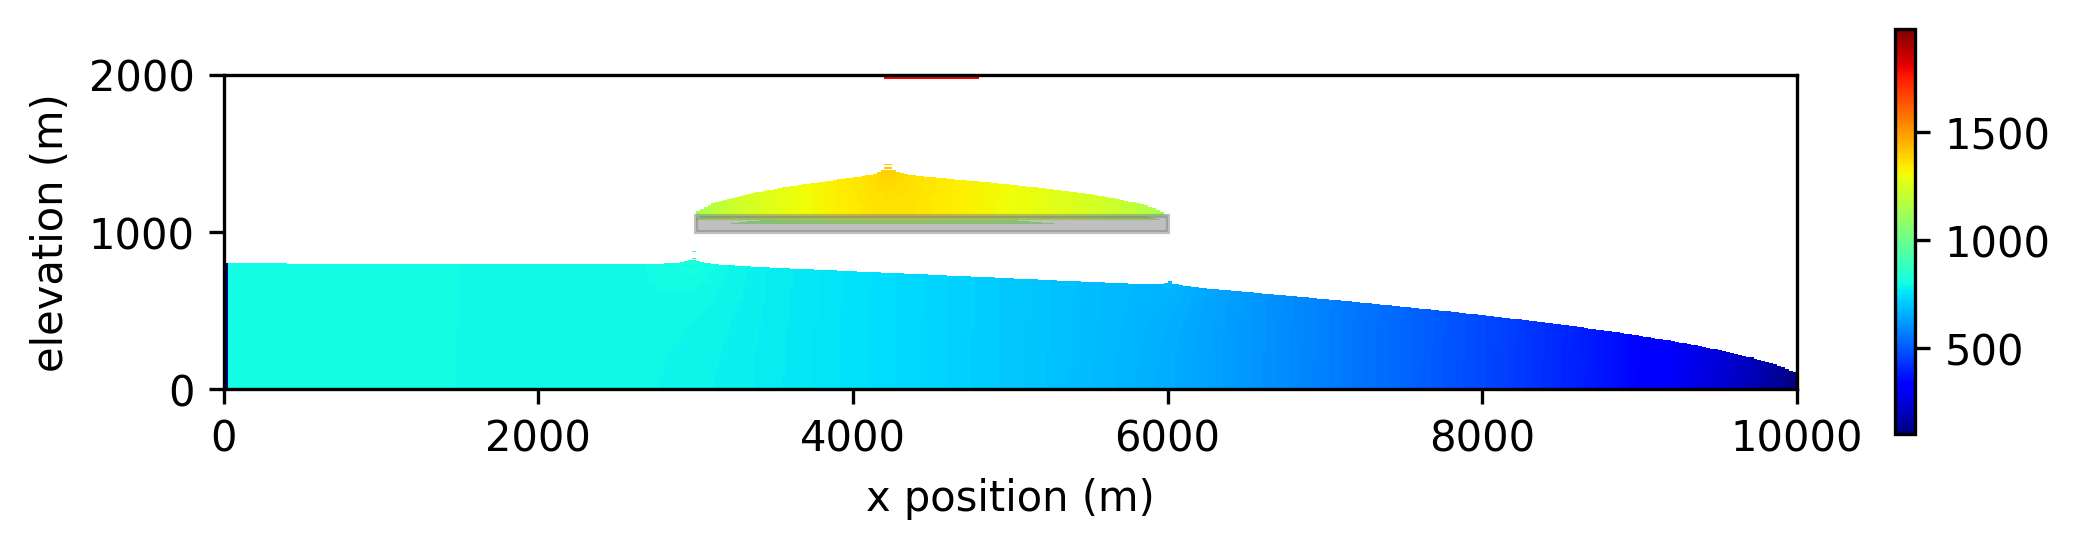

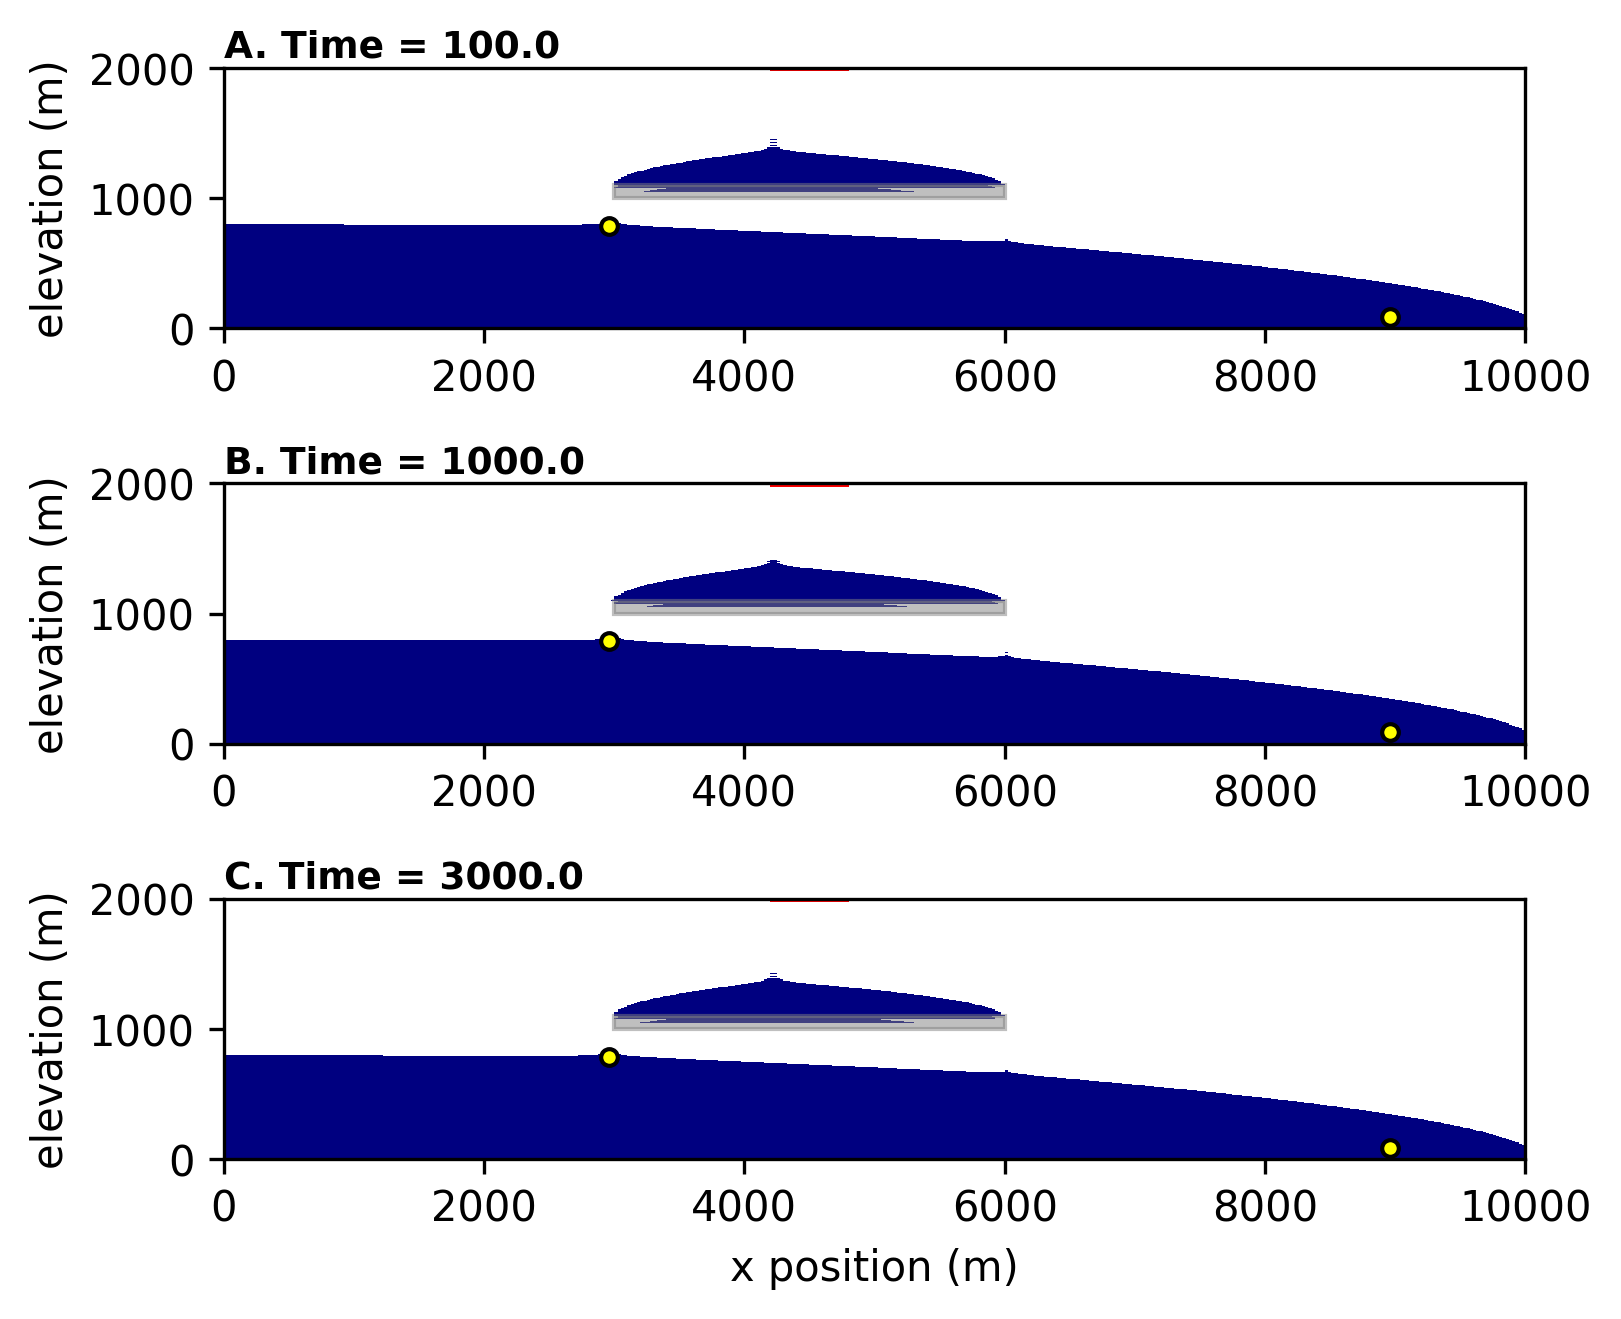

In [20]:
scenario(0)